<font color='green' size=+2><b>Самостоятельный проект: Сборный проект —2</b></font><br>

<font color='lightcoral'><b>Краткое описание исследования</b></font><br>
Нам предоставили данные компании «Работа с заботой», HR-аналитики которой помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. Этот процесс занимает немало времени и других трудозатрат. 

<font color='lightcoral'><b>Цель исследования</b></font><br>
Нам предстоит решить следующие задачи:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

<font color='lightcoral'><b>Задачи исследования</b></font><br>
- загрузить и ознакомится с данными, просмотреть нет ли в них пропусков/дублей/опечаток и тд.
- визуализировать количественные и качественные признаки, для поиска и определения выбросов
- провести исследовательский анализ, постараться выделить группы сотрудников и изучить данные детальнее внутри групп
- провести корреляционный анализ, посмотреть какие признаки зависят друг от друга, и при возможности - определить тип этой зависимости
- с помощью pipeline определить лучшую модель, которая поможет нам предсказать уровень удовлетворенности работой и вероятность увольнения сотрудника

<font color='lightcoral'><b>Исходные данные</b></font><br>
В обоих задачах, заказчик заранее разделил данные на 3 выборки - тренировочную, тестовые входные признаки и тестовый целевой признак.
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

<font color='green' size=+2><b>Задача 1</b></font><br>

<font color='green' size=+2><b>1.1. Загрузка и предобработка данных</b></font><br>

In [1]:
!pip install shap -q
!pip install scikit-learn==1.3.2 -q
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, mean_absolute_error, make_scorer, roc_auc_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_classification
import shap

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
df = pd.read_csv('train_job_satisfaction_rate.csv', delimiter=',', decimal='.')
features = pd.read_csv('test_features.csv', delimiter=',', decimal='.')
target = pd.read_csv('test_target_job_satisfaction_rate.csv', delimiter=',', decimal='.')

In [3]:
df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
features_and_target = features.merge(target, on='id', how='inner')
features_and_target.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [9]:
def df_info(data):
    return (data.info(), data.describe())

In [10]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


(None,
                   id  employment_years  supervisor_evaluation        salary  \
 count    4000.000000       4000.000000            4000.000000   4000.000000   
 mean   544957.621000          3.718500               3.476500  33926.700000   
 std    257883.104622          2.542513               1.008812  14900.703838   
 min    100954.000000          1.000000               1.000000  12000.000000   
 25%    322836.750000          2.000000               3.000000  22800.000000   
 50%    534082.500000          3.000000               4.000000  30000.000000   
 75%    771446.000000          6.000000               4.000000  43200.000000   
 max    999521.000000         10.000000               5.000000  98400.000000   
 
        job_satisfaction_rate  
 count            4000.000000  
 mean                0.533995  
 std                 0.225327  
 min                 0.030000  
 25%                 0.360000  
 50%                 0.560000  
 75%                 0.710000  
 max           

Имеем небольшое количество пропусков в столбцах dept и level, заполним их в pipeline. Значения mean и median во всех колонках не сильно отличаются, вероятно, слишком больших выбросов в данных нет.

In [11]:
df_info(features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


(None,
                   id  employment_years  supervisor_evaluation        salary
 count    2000.000000       2000.000000            2000.000000   2000.000000
 mean   552765.213500          3.666500               3.526500  34066.800000
 std    253851.326129          2.537222               0.996892  15398.436729
 min    100298.000000          1.000000               1.000000  12000.000000
 25%    339052.000000          1.000000               3.000000  22800.000000
 50%    550793.000000          3.000000               4.000000  30000.000000
 75%    765763.750000          6.000000               4.000000  43200.000000
 max    999029.000000         10.000000               5.000000  96000.000000)

Наблюдаем несколько пропусков в столбцах dept и workload, так же заполним их в pipeline.

In [12]:
df_info(target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


(None,
                   id  job_satisfaction_rate
 count    2000.000000             2000.00000
 mean   552765.213500                0.54878
 std    253851.326129                0.22011
 min    100298.000000                0.03000
 25%    339052.000000                0.38000
 50%    550793.000000                0.58000
 75%    765763.750000                0.72000
 max    999029.000000                1.00000)

In [13]:
df[df.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Дубликатов не наблюдаем.

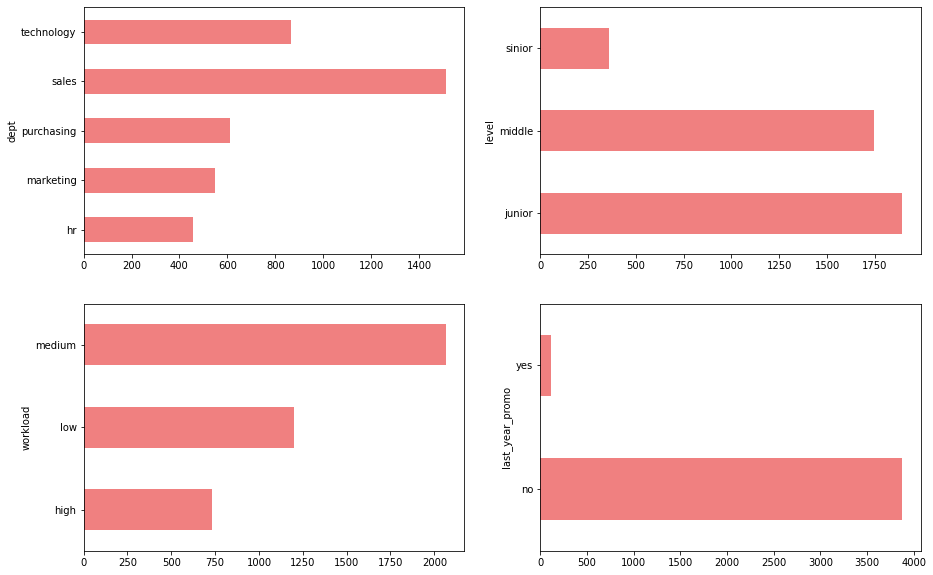

In [14]:
columns=['dept', 'level', 'workload', 'last_year_promo']
def plot_func(data, columns):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    for i, column in enumerate(columns):
        row_index = i // 2
        col_index = i % 2
        data.groupby(column)['id'].count().plot(kind='barh', ax=axes[row_index, col_index], color='lightcoral')
plot_func(df, columns)

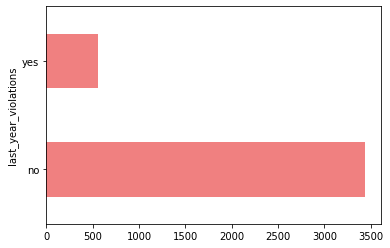

In [15]:
df.groupby('last_year_violations')['id'].count().plot(kind='barh', color='lightcoral');

In [16]:
df['dept'].value_counts(ascending=False)

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

Итак, у нас больше 30% сотрудников (1512чел) работают в отделе продаж, около 20%(866чел) - технические специалисты, 15%(610чел) - занимаются закупками, в отделе маркетинга 550 человек и 456 специалистов по найму сотрудников.

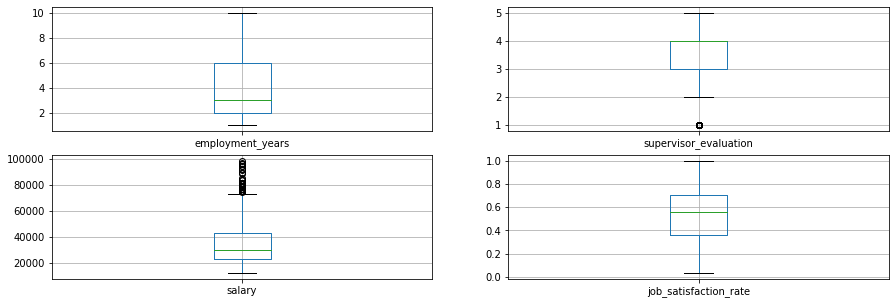

In [17]:
columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
def boxplot_func(data, columns_2):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
    for i, column in enumerate(columns_2):
        row_index = i // 2
        col_index = i % 2
        data.boxplot(column=column, ax=axes[row_index, col_index])
boxplot_func(df, columns_2)

В столбце employment_years можно заметить, что медиана приближена к нижнему значению, значит сотрудников которые работают в организации долго - меньше. 
В столбце supervisor_evaluation есть несколько выбросов ниже значения min.
Наблюдаем большое количество выбросов в столбце зарплата, в целом - можно было это ожидать, давайте рассмотрим по подробнее.

In [18]:
df.query('salary > 70000')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
32,176144,hr,sinior,high,3,no,no,1,72000,0.22
45,538347,technology,sinior,high,3,no,no,1,84000,0.21
141,128304,marketing,sinior,high,7,no,no,3,80400,0.48
196,486576,marketing,sinior,high,9,no,no,4,76800,0.66
198,763200,sales,sinior,high,6,yes,no,4,72000,0.81
...,...,...,...,...,...,...,...,...,...,...
3839,868744,technology,sinior,high,5,yes,no,4,97200,0.84
3894,459612,technology,sinior,high,9,no,no,4,88800,0.79
3902,612590,technology,sinior,high,8,no,no,3,76800,0.39
3942,215496,technology,sinior,medium,10,no,yes,4,70800,0.63


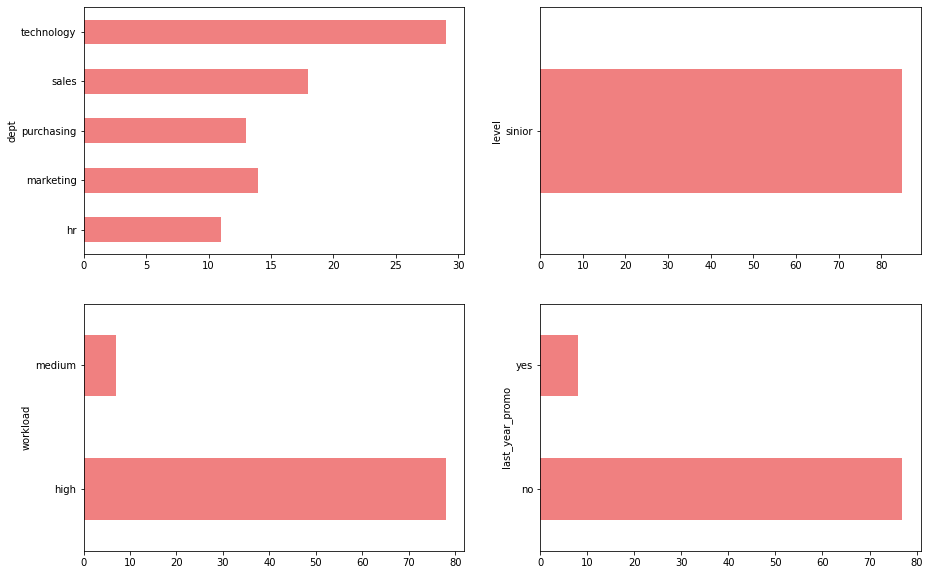

In [19]:
plot_func(df.query('salary > 70000'), columns)

Опять же, в целом ожидаемо и закономерно, высокие зарплаты имеют сотрудники с level sinior, в основном - это тех.специалисты и продажники, и они сильно загружены.

In [20]:
df.query('supervisor_evaluation < 2')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
18,848242,sales,middle,high,2,yes,no,1,50400,0.39
32,176144,hr,sinior,high,3,no,no,1,72000,0.22
45,538347,technology,sinior,high,3,no,no,1,84000,0.21
53,460328,technology,junior,high,1,no,no,1,37200,0.10
...,...,...,...,...,...,...,...,...,...,...
3877,947224,technology,junior,medium,3,no,no,1,30000,0.38
3949,157562,technology,middle,medium,3,no,no,1,49200,0.39
3972,134106,hr,middle,high,10,no,yes,1,57600,0.39
3988,806663,sales,middle,low,8,no,no,1,22800,0.39


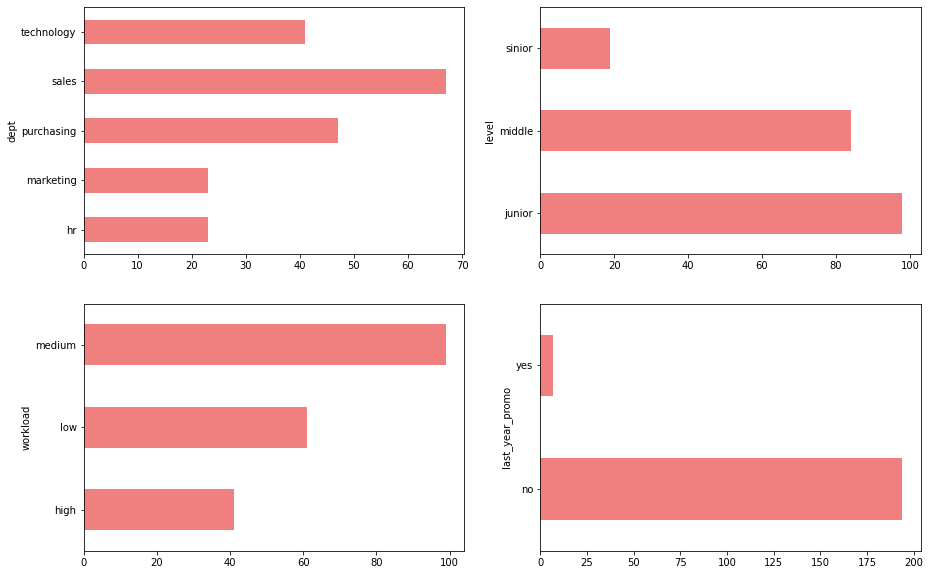

In [21]:
plot_func(df.query('supervisor_evaluation < 2'), columns)

Оценку от руководителя ниже 2 имеют в основном сотрудники с загрузкой medium и low, и в основном это сотрудники уровнял middle и junior.

Теперь посмотрим на features:

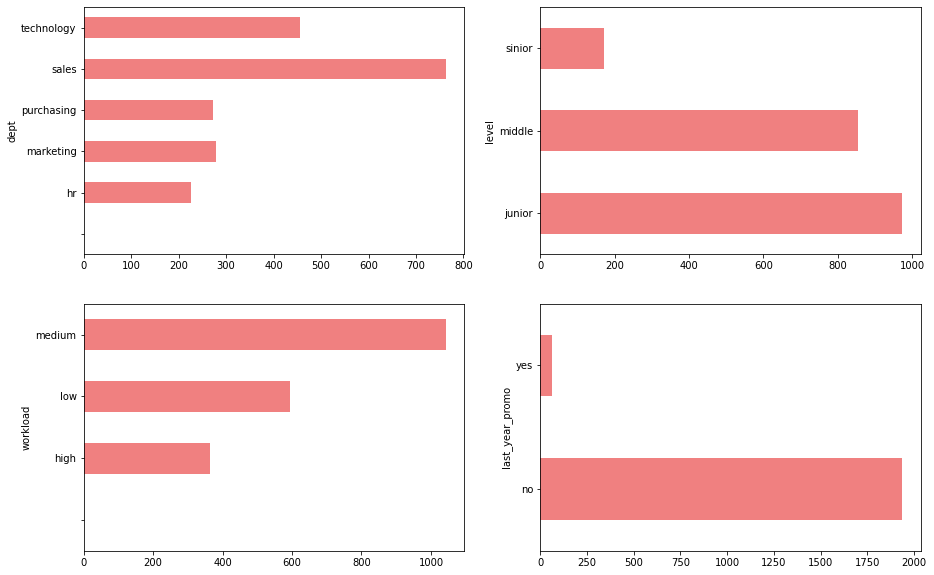

In [22]:
plot_func(features, columns)

Заменим значения с пробелом на np.nan

In [23]:
features['workload'] = features['workload'].replace(' ', np.nan)
features['dept'] = features['dept'].replace(' ', np.nan)

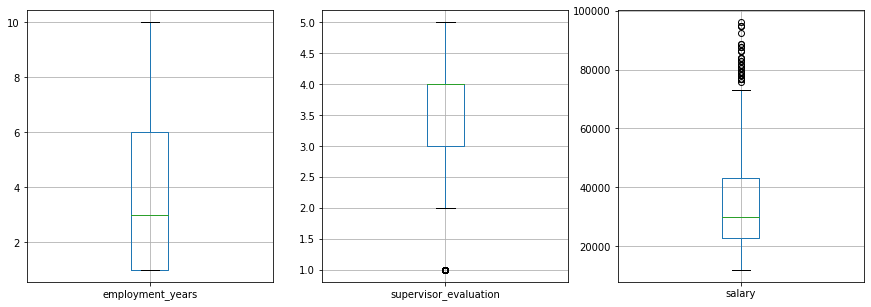

In [24]:
columns_3 = ['employment_years', 'supervisor_evaluation', 'salary']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, column in enumerate(columns_3):
    col_index = i % 3
    features.boxplot(column=column, ax=axes[col_index])

Ситуация аналогична df.

<font color='green' size=+2><b>1.2. Исследовательский анализ данных</b></font><br>

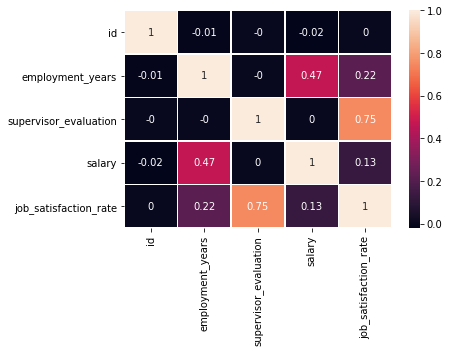

In [25]:
sns.heatmap(df.corr(method='spearman').round(2), linewidths=.5, annot=True);

Наиболее коррелирующий с целевым признаком признак столбец, это supervisor_evaluation

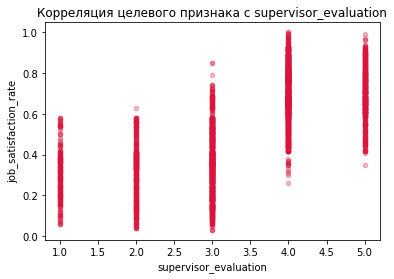

In [26]:
df.plot(x='supervisor_evaluation', y='job_satisfaction_rate', kind='scatter', alpha=0.3, c=np.array(['crimson']))
plt.title('Корреляция целевого признака с supervisor_evaluation')
plt.xlabel('supervisor_evaluation')
plt.ylabel('job_satisfaction_rate');

Зависимость явно не линейная.

Все числовые признаки необходимо стандартизировать, поскольку значения лежат в диапазоне от сотых долей до 100 тысяч.
Категориальные признаки - кодировать:
 - ordinalEncoder для 'level' и 'workload', поскольку их значения можно оценить и сравнить между собой.
 - oneHotEncoder для 'dept', 'last_year_promo', 'last_year_violations'

<font color='green' size=+2><b>1.3. Подготовка данных</b></font><br>

In [27]:
df = df.set_index('id')
df[df.duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
302957,purchasing,junior,low,1,no,no,4,15600,0.61
752399,sales,middle,low,7,no,no,4,28800,0.77
802286,sales,junior,medium,1,no,no,4,21600,0.43
167303,sales,junior,medium,1,no,no,3,24000,0.34
191841,sales,junior,medium,1,no,no,5,21600,0.44
...,...,...,...,...,...,...,...,...,...
737303,sales,middle,medium,3,no,no,4,33600,0.47
281204,technology,junior,low,2,no,no,4,15600,0.68
261436,sales,middle,low,3,no,no,3,22800,0.18


В датафрейме с обучающими данными имеется 245 дубликатов, однако им всем присвоины разные id. Избавимся от таких записей.

In [28]:
df_clear = df.drop_duplicates()
len(df_clear)

3755

In [29]:
features_and_target = features_and_target.set_index('id')[features_and_target.set_index('id').duplicated()]

In [30]:
def smape(y_test, pred):
    metric = 100/len(y_test)*np.sum(2*np.abs(pred-y_test)/(np.abs(y_test)+np.abs(pred)))
    return metric

scorer_smape = make_scorer(smape, greater_is_better=False)

In [31]:
df_clear[df_clear.duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,


In [32]:
X_train = df_clear.drop(['job_satisfaction_rate'], axis=1)
#X_test = features
X_test = features_and_target.drop(['job_satisfaction_rate'], axis=1)
y_train = df_clear['job_satisfaction_rate']
#y_test = target['job_satisfaction_rate']
y_test = features_and_target['job_satisfaction_rate']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3755, 8), (83, 8), (3755,), (83,))

In [33]:
# списки с названиями признаков
ohe_columns = ['dept',
               'last_year_promo',
               'last_year_violations']

ord_columns = ['level',
               'workload']

num_columns = ['employment_years',
               'supervisor_evaluation',
               'salary']

# пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    
    # словарь для модели LinearRegression
    {'models': [LinearRegression()],
     'models__fit_intercept': [True, False],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # словарь для модели DecisionTreeRegressor
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': (None, *range(2,8)),
     'models__max_features': range(2,50),
     'models__min_samples_split': range(1,50),#[5, 10, 20, 40],
     'models__min_samples_leaf': range(1,50),#[2, 4, 8, 16],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    #словарь для модели RandomForestRegressor
    {'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
     'models__n_estimators': range(2,7),
     'models__max_depth': range(2,10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]

rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring=scorer_smape,
    n_jobs=-1,
    error_score='raise'
)

In [34]:
rs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', rs.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [35]:
y_pred = rs.best_estimator_.predict(X_test)
print(f'Метрика sMAPE на тестовой выборке: {smape(y_test, y_pred)}')

Метрика sMAPE на тестовой выборке: 12.768653413162735


<font color='green' size=+2><b>1.4. Выводы к задаче 1</b></font><br>

В нашем случае, модель DecisionTreeRegressor с параметрами max_features=6, min_samples_leaf=26, min_samples_split=35 справилась лучше конкурентов. 

<font color='green' size=+2><b>Задача 2</b></font><br>

<font color='green' size=+2><b>2.1. Загрузка данных</b></font><br>

In [36]:
train_quit = pd.read_csv('train_quit.csv', delimiter=',', decimal='.')
test_features = pd.read_csv('test_features.csv', delimiter=',', decimal='.')
test_target = pd.read_csv('test_target_quit.csv', delimiter=',', decimal='.')

In [37]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [38]:
df_info(train_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


(None,
                   id  employment_years  supervisor_evaluation        salary
 count    4000.000000       4000.000000            4000.000000   4000.000000
 mean   552099.283750          3.701500               3.474750  33805.800000
 std    260158.031387          2.541852               1.004049  15152.415163
 min    100222.000000          1.000000               1.000000  12000.000000
 25%    327785.750000          2.000000               3.000000  22800.000000
 50%    546673.000000          3.000000               4.000000  30000.000000
 75%    781497.750000          6.000000               4.000000  43200.000000
 max    999915.000000         10.000000               5.000000  96000.000000)

In [39]:
df_info(test_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


(None,
                   id  employment_years  supervisor_evaluation        salary
 count    2000.000000       2000.000000            2000.000000   2000.000000
 mean   552765.213500          3.666500               3.526500  34066.800000
 std    253851.326129          2.537222               0.996892  15398.436729
 min    100298.000000          1.000000               1.000000  12000.000000
 25%    339052.000000          1.000000               3.000000  22800.000000
 50%    550793.000000          3.000000               4.000000  30000.000000
 75%    765763.750000          6.000000               4.000000  43200.000000
 max    999029.000000         10.000000               5.000000  96000.000000)

<font color='green' size=+2><b>2.2. Предобработка данных</b></font><br>

In [40]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [41]:
train_quit.set_index('id')[train_quit.set_index('id').duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
873412,technology,junior,medium,2,no,no,4,31200,no
749683,sales,middle,low,8,no,no,4,19200,no
689526,marketing,middle,low,6,no,no,3,30000,no
786443,purchasing,middle,low,6,no,no,4,19200,no
362060,sales,junior,low,1,no,no,4,12000,yes
...,...,...,...,...,...,...,...,...,...
632886,sales,junior,low,3,no,no,4,12000,no
387733,marketing,middle,medium,5,no,no,3,44400,no
588809,sales,junior,medium,4,no,no,3,26400,no


У нас есть много дубликатов в тренировочной выборке, избавимся от них перед разделением на тестовые выборки и обучением модели.

In [42]:
test_features_target = test_features.merge(test_target, on='id', how='inner')
test_features_target.set_index('id')[test_features_target.set_index('id').duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
523542,marketing,junior,low,1,no,no,3,16800,yes
582128,sales,middle,high,5,no,no,4,48000,no
482624,technology,middle,medium,4,yes,no,2,44400,no
770429,hr,junior,medium,1,no,no,4,30000,no
493196,sales,junior,low,1,no,no,4,12000,yes
...,...,...,...,...,...,...,...,...,...
760964,sales,junior,medium,3,no,no,5,21600,no
380255,sales,middle,medium,8,no,no,4,38400,no
393147,marketing,junior,low,3,no,no,3,20400,yes


Эти дубликаты удалим перед разделением данных на выборки и обучением модели.

Взглянем на неявные дубликаты в данных

In [43]:
new_columns=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
for el in train_quit[new_columns]:
    print(train_quit[el].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [44]:
test_features_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for el in test_features[test_features_col]:
    print(test_features[el].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Заменим значения с пробелом на np.nan

In [45]:
test_features['workload'] = test_features['workload'].replace(' ', np.nan)
test_features['dept'] = test_features['dept'].replace(' ', np.nan)

In [46]:
test_target['quit'].unique()

array(['yes', 'no'], dtype=object)

<font color='green' size=+2><b>2.3. Исследовательский анализ</b></font><br>

In [47]:
train_quit.query('quit == "yes"')['workload'].value_counts(normalize=True)

low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64

In [48]:
train_quit.query('quit == "yes"')['dept'].value_counts(normalize=True)

sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64

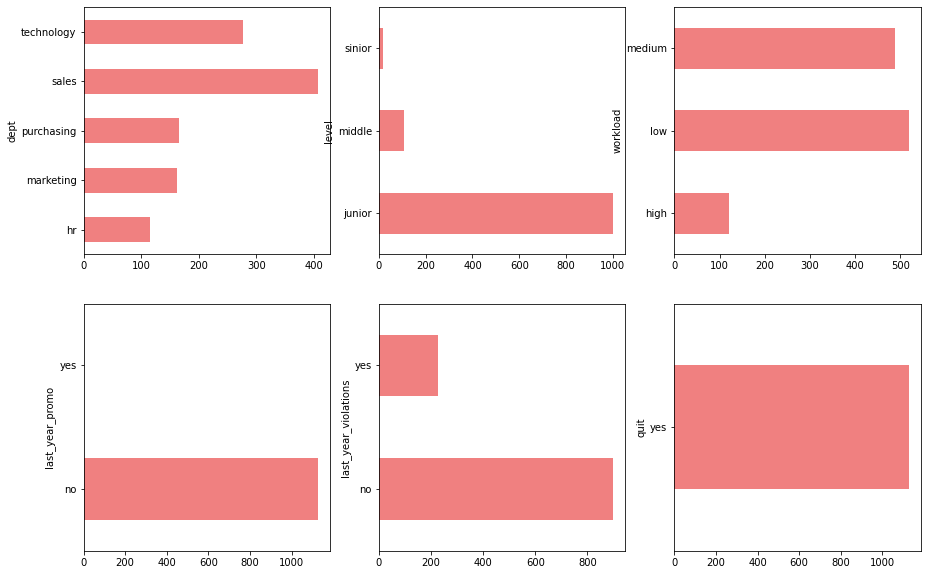

In [49]:
def plot_func(data, columns):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    for i, column in enumerate(columns):
        row_index = i // 3
        col_index = i % 3
        data.groupby(column)['id'].count().plot(kind='barh', ax=axes[row_index, col_index], color='lightcoral')
plot_func(train_quit.query('quit == "yes"'), new_columns)

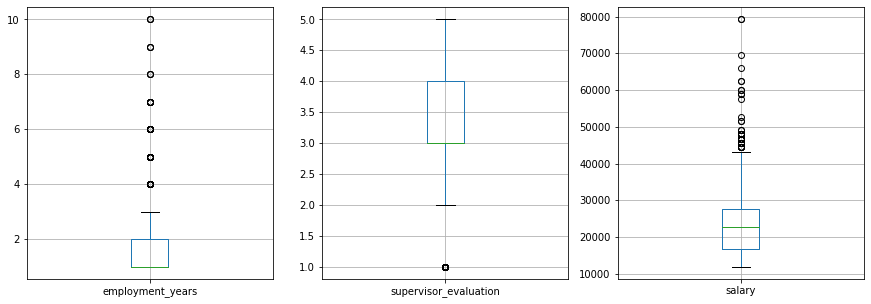

In [50]:
new_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, column in enumerate(new_columns_2):
    col_index = i % 3
    train_quit.query('quit == "yes"').boxplot(column=column, ax=axes[col_index])

В большинстве своем, сотрудники которые хотят уволится это прожадники, за ними идут техспециалисты, что одних что других не повышали за последний год, и в основном - это junior специалисты. Также, в основном это люди со стажем до 3 лет. Ну и наверное основная причина, это зарплата. Пока мы можем сказать, что она 75% уволившихся сотрудников получали менее 30 тысяч. Вероятнее, выбросы - присущи техническим специалистам, давайте проверим.

In [51]:
train_quit.query('quit == "yes" and salary > 50000')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
173,552263,marketing,middle,high,2,no,no,3,62400,yes
194,269621,sales,middle,high,4,no,no,4,58800,yes
384,171652,hr,middle,high,4,no,yes,4,62400,yes
848,633488,technology,sinior,high,6,no,no,4,79200,yes
1273,645336,sales,sinior,high,3,no,no,5,66000,yes
1728,205905,technology,sinior,high,9,no,no,4,79200,yes
2271,173956,purchasing,middle,high,6,no,no,2,57600,yes
2525,848797,technology,middle,medium,3,no,no,4,51600,yes
2753,474157,sales,middle,high,2,no,no,4,58800,yes
2829,719562,technology,middle,medium,6,no,no,4,52800,yes


Уволившийся персонал, который получал больше 50.000 все имели по большей части высокую загруженность, либо среднюю. Проработали они при этом в компании не менее 2 лет, и они либо miidle либо sinior. Преобладания какого-либо отдела в этом срезе не наблюдается.

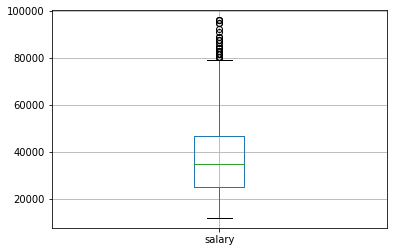

In [52]:
train_quit.query('quit == "no"').boxplot(column='salary');

In [53]:
train_quit.query('quit == "yes"')['salary'].mean()

23885.106382978724

In [54]:
train_quit.query('quit == "no"')['salary'].mean()

37702.22841225627

Средние зарплаты тех кто уволился на 13.000 меньше чем у тех, кто остался на рабочем месте. Зарплата один из основополагающих фактов для работы, очевидно, что сотрудников такая разница в оплате труда не устраивала.

In [55]:
target

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
...,...,...
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26


In [56]:
merged_target = target.merge(test_target, how='inner', on='id')
merged_target#.set_index('id')[merged_target.set_index('id').duplicated()]

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes
...,...,...,...
1995,405257,0.28,no
1996,370925,0.21,yes
1997,857722,0.39,no
1998,303402,0.26,yes


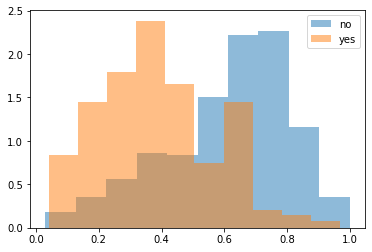

In [57]:
pyplot.hist(merged_target.query('quit == "no"')['job_satisfaction_rate'], 
            bins=10, alpha=0.5, label='no', density=True)
pyplot.hist(merged_target.query('quit == "yes"')['job_satisfaction_rate'], 
            bins=10, alpha=0.5, label='yes', density=True)
pyplot.legend(loc='upper right')
pyplot.show()

Исходя из визуализации, можно подтвердить информацию, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Пик у уволившихся сотрудников, около 0.4 а у тех кто продолжает работать - в промежутке от 0.6 до 0.8

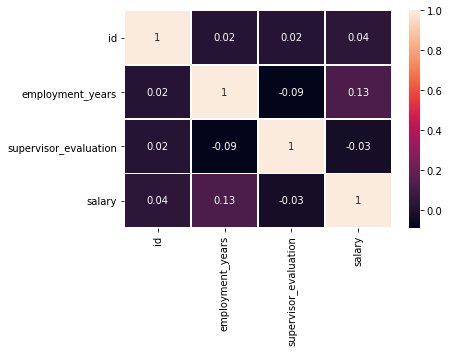

In [58]:
sns.heatmap(train_quit.query('quit == "yes"').corr(method='spearman').round(2), linewidths=.5, annot=True);

In [59]:
train_quit.query('quit == "yes"')['employment_years'].mean()

1.8448581560283688

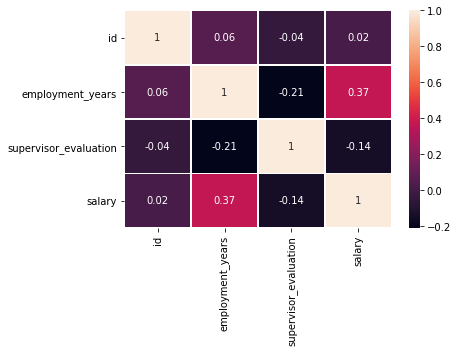

In [60]:
sns.heatmap(train_quit.query('quit == "no"').corr(method='spearman').round(2), linewidths=.5, annot=True);

In [61]:
train_quit.query('quit == "no"')['employment_years'].mean()

4.430710306406685

По матрице корреляции можно заметить, что у сотрудников, которые не уволились наблюдается зависимость между длительностью работы в организации и зарплатой. Оправдано, ведь в среднем у них стаж работы более чем в 2 раза больше, логично что они двигаются по карьерной лестнице, и получают прибавки к зарплате. 

Между остальными признаками, корреляция отсутствует. 

<font color='green' size=+2><b>2.4. Добавление нового входного признака</b></font><br>

In [62]:
test_features_target_clear = test_features_target.set_index('id').drop_duplicates()
train_quit_clear = train_quit.set_index('id').drop_duplicates()

In [63]:
test_features_target_clear

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...
609235,hr,sinior,high,2,no,no,3,81600,no
630684,technology,junior,high,2,no,no,4,48000,no
497976,technology,middle,medium,3,no,no,4,52800,no


In [64]:
X_train_q = train_quit_clear
X_test_q = test_features_target_clear
y_train_q = merged_target['job_satisfaction_rate']
y_test_q = merged_target['job_satisfaction_rate']
X_train_q.shape, X_test_q.shape, y_train_q.shape, y_test_q.shape

((2587, 9), (1496, 9), (2000,), (2000,))

In [65]:
X_train_q.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'],
      dtype='object')

In [66]:
X_test_q.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'],
      dtype='object')

In [67]:
y_pred_q = rs.best_estimator_.predict(X_test_q)

In [68]:
y_pred_qq = rs.best_estimator_.predict(X_train_q)

In [69]:
test_features_target_clear['job_satisfaction_rate'] = y_pred_q
train_quit_clear['job_satisfaction_rate'] = y_pred_qq

<font color='green' size=+2><b>2.5. Подготовка данных</b></font><br>

In [71]:
X_train_s = train_quit_clear.drop(['quit'], axis=1)
X_test_s = test_features_target_clear.drop(['quit'], axis=1)
y_train_s = train_quit_clear['quit']
y_test_s = test_features_target_clear['quit']

X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape

((2587, 9), (1496, 9), (2587,), (1496,))

In [72]:
X_train_s.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

In [73]:
X_test_s.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

In [74]:
#закодируем целевой признак
label_encoder = LabelEncoder()
 
y_train_s = label_encoder.fit_transform(y_train_s)
y_test_s = label_encoder.transform(y_test_s)

In [75]:
# списки с названиями признаков
ohe_columns_2 = ['dept',
                'last_year_promo',
                'last_year_violations']

ord_columns_2 = ['level',
                'workload']

num_columns_2 = ['employment_years',
                'supervisor_evaluation',
                'salary',
                'job_satisfaction_rate']

# пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe_2 = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_columns_2),
        ('ord', ord_pipe_2, ord_columns_2),
        ('num', MinMaxScaler(), num_columns_2)
    ], 
    remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2= Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('selector', SelectKBest()),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_2 = [
    
    # словарь для модели LogisticRegression
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
     'selector__k': range(2, 10)
    },
    
    # словарь для модели DecisionTreeClassifier
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(1,9),
     'models__max_features': range(1,100),
     'models__min_samples_split': range(1,100),
     'models__min_samples_leaf': range(1,100),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
     'selector__k': range(2, 10)
    },
    
    #словарь для модели SVC
    {'models': [SVC(random_state=RANDOM_STATE)],
     'models__C':[0.1,1,10],
     'models__kernel':['linear'],
     'models__degree':[1,3,4],
     'models__gamma':[1,0.1,0.01],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
     'selector__k': range(2, 10)
    }
]

rs_2 = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

In [76]:
rs_2.fit(X_train_s, y_train_s)

print('Лучшая модель и её параметры:\n\n', rs_2.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', rs_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [77]:
y_pred_last = rs_2.best_estimator_.predict_proba(X_testz)[:, 1]
print(f'Метрика  на тестовой выборке: {round(roc_auc_score(y_test_s, y_pred_last),2)}')

Метрика  на тестовой выборке: 0.9


<font color='green' size=+2><b>2.6. Вывод</b></font><br>


В результате работы нашего pipeline мы отобрали модель DecisionTreeClassifier с параметрами max_depth=4, max_features=21, min_samples_leaf=4, min_samples_split=6 - качество которой на тренировочной и тестовой выборках составило 0.9!

Для решения задачи компании «Работа с заботой» нам сперва пришлось немного поработать с предоставленными нам данными, а именно:
- избавиться от пропусков и пустых значений
- удалить дубликаты


Нам пришлось присмотреться к сотрудникам, которые уже уволились, что бы составить портрет человека, который в ближайшее время захочет сменить работу. Для этого мы сегментировали сотрудников на тех кто уволился, и кто продолжается трудиться в организации. После, мы изучили средние значения количественных признаков, визуализировали из загруженность, заработок, уровень их компетенций и отделы, в которых они трудятся. 

Исходя из этого этапа, мы составили приблизительный портрет сотрудника, который в ближайшее время, скорее всего, захочет сменить место работы:
- специалист уровня junior
- с низкой или средней загруженностью
- работающий в отедел продаж, либо технический специалист
- которого не повышали за последний год
- медианная зарплата которого 22800 рублей в месяц
- стаж работы в организации которых, как правило - не более 2 лет

На первом этапе нашей работы, мы реализовали модель регрессии, которая может определять уровень удовлетворенности сотрудника внутри организации. Далее, мы добавили этот признак в обучающий датафрейм второй модели, которая уже определяет вероятность того, уволится ли сотрудник или нет.

Теперь, организация «Работа с заботой» может пользоватся нашей разработкой, и уделять больше внимания сотрудникам, которые находятся "в зоне риска", и предпринимать необходимые решения, например - повысить зарплату, либо урегулировать нагрузку, возможно стоит доверять сотрудникам уровня junior более сложные и интересные задачи, при успешном выполнении которых повышение в должности и оплате не заставит себя ждать. Конкретно для сотружников отдела продаж, стоит пересмотреть (рассмотреть) систему мотивации, поскольку большая часть текучки кадров относится именно к отделу продаж. Но, все эти решения конечно же нужно принимать избирательно, наверняка из списка жалающих уволиться, найдутся и такие сотрудники, которых организация не слишком стремится сохранить в строю. 

Также, рекомендуем компании «Работа с заботой» обратить внимание на процесс сбора данных, в нем явно виднеется бреш, поскольку одинаковые записи снова и снова попадают в витрины, но каждый раз под новым id. В дальнейшем, это может привести к серьезным проблемам с точностью прогнозирования или расчета каких-либо метрик/показателей.